# 더욱 자세한 모델설명은 Pytorch 홈페이지 참조

https://pytorch.org/vision/main/models/convnext.html

In [1]:
import torch
import torch.nn as nn # 신경망들이 들어있는 모듈
import torch.optim as optim # 최적화 알고리즘들이 들어있는 모듈
import torch.nn.init as init # 텐서에 초기값을 줌

import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torch.utils.data as data
from torchvision import transforms # transforms는 전처리를 위한 모듈

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 모듈

from torch.utils.data.sampler import SubsetRandomSampler #label과 이미지를 한번에 가져오기위한 Sampler 라이브러리

import numpy as np
import matplotlib.pyplot as plt # 시각화를 위한 모듈
#=======================================================================================
#from torchvision.models import convnext_tiny, convnext_small, convnext_base, convnext_large
from ConvNext_V1 import convnext_tiny, convnext_small, convnext_base, convnext_large

In [2]:
# 정규화에 사용할 평균과 표준 편차
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

#Image augmentation is used to train the model
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std),
])
#Only the data is normalaized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std),
])

In [3]:
# Compose는 여러 transform을 적용할 수 있도록 묶어주는 역할
train_imgs = ImageFolder("./Cifar_100/train_image", transform = transform_train)
test_imgs = ImageFolder("./Cifar_100/test_image", transform = transform_test)

print("train_imgs len : ", len(train_imgs)) #imagefolder객체
print("test_imgs len : ", len(test_imgs)) #imagefolder객체

train_imgs len :  50000
test_imgs len :  10000


In [4]:
# train과 validation으로 나누기
valid_size = 0.2

num_train = len(train_imgs)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [5]:
split

10000

In [6]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [7]:
# prepare data loaders (combine dataset and sampler)
batch_size = 100
learning_rate = 0.0002
num_epoch = 200

train_loader = torch.utils.data.DataLoader(train_imgs, 
                                           batch_size = batch_size, 
                                           sampler = train_sampler, 
                                           num_workers = 3)

valid_loader = torch.utils.data.DataLoader(train_imgs, 
                                           batch_size = batch_size, 
                                           sampler = valid_sampler, 
                                           num_workers = 3)

test_loader = torch.utils.data.DataLoader(test_imgs, 
                                          batch_size = batch_size, 
                                          num_workers = 3)

# 이미지 확인

In [8]:
len(train_imgs)

50000

C:\Users\cai-tj\AppData\Local\Temp/ipykernel_1796/828376984.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3281.)
  plt.imshow(image.T) # imshow는 (m, n, 3)의 형태를 받으므로 Transpose
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image tensor 예시 :  tensor([[[-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957],
         [ 0.1420,  0.1274,  0.0248,  ...,  0.6405,  0.0248, -1.8957],
         [ 0.0248,  0.1127,  0.1274,  ...,  1.0363,  0.3619, -1.8957],
         ...,
         [-0.1805, -0.3417, -0.0485,  ...,  0.7871,  0.8018, -1.8957],
         [ 0.0394, -0.2978, -0.1365,  ...,  0.8897,  0.9190, -1.8957],
         [ 0.5379,  0.1127, -0.1805,  ...,  0.6845,  0.8897, -1.8957]],

        [[-1.8975, -1.8975, -1.8975,  ..., -1.8975, -1.8975, -1.8975],
         [-0.0169, -0.0322, -0.1393,  ...,  0.5640, -0.1087, -1.8975],
         [-0.1393, -0.0475, -0.0322,  ...,  1.0838,  0.3194, -1.8975],
         ...,
         [-0.3839, -0.5673, -0.2616,  ...,  0.6405,  0.6558, -1.8975],
         [-0.1393, -0.4909, -0.3227,  ...,  0.7475,  0.7781, -1.8975],
         [ 0.3806, -0.0628, -0.3839,  ...,  0.5334,  0.7475, -1.8975]],

        [[-1.5965, -1.5965, -1.5965,  ..., -1.5965, -1.5965, -1.5965],
         [-0.0199, -0.0483

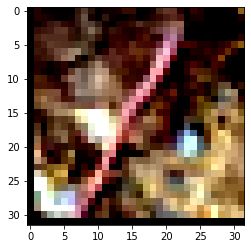

In [9]:
image, label = train_imgs[49998] # 랜덤한 이미지 한장 뽑아보기
print ("image tensor 예시 : ", image)

# 컬러이므로 3채널, 32-32픽셀 이미지
print("\n이미지 크기 : ", image.shape)
print("이미지 라벨 : ", label)

plt.imshow(image.T) # imshow는 (m, n, 3)의 형태를 받으므로 Transpose

In [10]:
train_imgs.class_to_idx # 99번 라벨은 worm이므로 지렁이

{'apple': 0,
 'aquarium_fish': 1,
 'baby': 2,
 'bear': 3,
 'beaver': 4,
 'bed': 5,
 'bee': 6,
 'beetle': 7,
 'bicycle': 8,
 'bottle': 9,
 'bowl': 10,
 'boy': 11,
 'bridge': 12,
 'bus': 13,
 'butterfly': 14,
 'camel': 15,
 'can': 16,
 'castle': 17,
 'caterpillar': 18,
 'cattle': 19,
 'chair': 20,
 'chimpanzee': 21,
 'clock': 22,
 'cloud': 23,
 'cockroach': 24,
 'couch': 25,
 'crab': 26,
 'crocodile': 27,
 'cup': 28,
 'dinosaur': 29,
 'dolphin': 30,
 'elephant': 31,
 'flatfish': 32,
 'forest': 33,
 'fox': 34,
 'girl': 35,
 'hamster': 36,
 'house': 37,
 'kangaroo': 38,
 'keyboard': 39,
 'lamp': 40,
 'lawn_mower': 41,
 'leopard': 42,
 'lion': 43,
 'lizard': 44,
 'lobster': 45,
 'man': 46,
 'maple_tree': 47,
 'motorcycle': 48,
 'mountain': 49,
 'mouse': 50,
 'mushroom': 51,
 'oak_tree': 52,
 'orange': 53,
 'orchid': 54,
 'otter': 55,
 'palm_tree': 56,
 'pear': 57,
 'pickup_truck': 58,
 'pine_tree': 59,
 'plain': 60,
 'plate': 61,
 'poppy': 62,
 'porcupine': 63,
 'possum': 64,
 'rabbit': 65,

### Run

In [11]:
torch.cuda.is_available()

True

In [12]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [13]:
torch.cuda.device_count()

1

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 기본사용

In [15]:
model = convnext_base(weight = 'ConvNeXt_Base_Weights.IMAGENET1K_V1', num_classes = 100)
model.to(device)

loss_func = nn.CrossEntropyLoss()

#Adam 대신 AdamW 사용
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [16]:
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, num_epoch+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        data = image.to(device)
        target = label.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = loss_func(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        
    ######################    
    # validate the model #
    ######################    
    model.eval()   
    for batch_idx, (image, label) in enumerate(valid_loader):
        data = image.to(device)
        target = label.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = loss_func(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'ConvNext_V1.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 4.019372 	Validation Loss: 3.800638
Validation loss decreased (inf --> 3.800638).  Saving model ...
Epoch: 2 	Training Loss: 3.654326 	Validation Loss: 3.484379
Validation loss decreased (3.800638 --> 3.484379).  Saving model ...
Epoch: 3 	Training Loss: 3.386980 	Validation Loss: 3.292136
Validation loss decreased (3.484379 --> 3.292136).  Saving model ...
Epoch: 4 	Training Loss: 3.212203 	Validation Loss: 3.123619
Validation loss decreased (3.292136 --> 3.123619).  Saving model ...
Epoch: 5 	Training Loss: 3.066246 	Validation Loss: 3.034568
Validation loss decreased (3.123619 --> 3.034568).  Saving model ...
Epoch: 6 	Training Loss: 2.953108 	Validation Loss: 2.938806
Validation loss decreased (3.034568 --> 2.938806).  Saving model ...
Epoch: 7 	Training Loss: 2.836140 	Validation Loss: 2.895538
Validation loss decreased (2.938806 --> 2.895538).  Saving model ...
Epoch: 8 	Training Loss: 2.731141 	Validation Loss: 2.772381
Validation loss decreased (2.89553

Epoch: 118 	Training Loss: 0.053933 	Validation Loss: 5.441313
Epoch: 119 	Training Loss: 0.054929 	Validation Loss: 5.437253
Epoch: 120 	Training Loss: 0.060600 	Validation Loss: 5.405433
Epoch: 121 	Training Loss: 0.061482 	Validation Loss: 5.417670
Epoch: 122 	Training Loss: 0.060691 	Validation Loss: 5.418720
Epoch: 123 	Training Loss: 0.061906 	Validation Loss: 5.429848
Epoch: 124 	Training Loss: 0.055459 	Validation Loss: 5.411379
Epoch: 125 	Training Loss: 0.057392 	Validation Loss: 5.517505
Epoch: 126 	Training Loss: 0.061894 	Validation Loss: 5.395721
Epoch: 127 	Training Loss: 0.051296 	Validation Loss: 5.400082
Epoch: 128 	Training Loss: 0.053204 	Validation Loss: 5.341157
Epoch: 129 	Training Loss: 0.055723 	Validation Loss: 5.494224
Epoch: 130 	Training Loss: 0.058578 	Validation Loss: 5.371443
Epoch: 131 	Training Loss: 0.054916 	Validation Loss: 5.448200
Epoch: 132 	Training Loss: 0.055003 	Validation Loss: 5.501693
Epoch: 133 	Training Loss: 0.048774 	Validation Loss: 5

In [17]:
correct = 0
total = 0

# evaluate model
model.load_state_dict(torch.load('ConvNext_V1.pt'))
model.eval()

with torch.no_grad():
    for image,label in test_loader:
        x = image.to(device)
        y= label.to(device)

        output = model.forward(x)
        #print("output", output.shape)
        #print("output", output)
        
        # torch.max함수는 (최댓값,index)를 반환 
        _,output_index = torch.max(output,1)
        #print("_",_.shape)
        #print("_",_)
        #print("index", output_index)
        
        # 전체 개수 += 라벨의 개수
        total += label.size(0)
        
        # 도출한 모델의 index와 라벨이 일치하면 correct에 개수 추가
        correct += (output_index == y).sum().float()
    
    # 정확도 도출
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 13.969999313354492%


In [18]:
classes= train_imgs.classes

In [19]:
classes[0]

'apple'

In [20]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))

train_on_gpu = torch.cuda.is_available()

model.load_state_dict(torch.load('ConvNext_V1.pt'))

model.eval()
# iterate over test data
for batch_idx, (image, label) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    data = image.to(device)
    target = label.to(device)
    output = model(data)
    # calculate the batch loss
    loss = loss_func(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
   
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(100):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i],np.sum(class_correct[i]), 
                                                         np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                      np.sum(class_correct), 
                                                      np.sum(class_total)))

Test Loss: 2.523041

Test Accuracy of apple: 75% (75/100)
Test Accuracy of aquarium_fish: 48% (48/100)
Test Accuracy of  baby: 37% (37/100)
Test Accuracy of  bear: 13% (13/100)
Test Accuracy of beaver: 35% (35/100)
Test Accuracy of   bed: 37% (37/100)
Test Accuracy of   bee: 49% (49/100)
Test Accuracy of beetle: 41% (41/100)
Test Accuracy of bicycle: 41% (41/100)
Test Accuracy of bottle: 42% (42/100)
Test Accuracy of  bowl: 17% (17/100)
Test Accuracy of   boy: 22% (22/100)
Test Accuracy of bridge: 45% (45/100)
Test Accuracy of   bus: 32% (32/100)
Test Accuracy of butterfly: 26% (26/100)
Test Accuracy of camel: 25% (25/100)
Test Accuracy of   can: 31% (31/100)
Test Accuracy of castle: 66% (66/100)
Test Accuracy of caterpillar: 44% (44/100)
Test Accuracy of cattle: 27% (27/100)
Test Accuracy of chair: 73% (73/100)
Test Accuracy of chimpanzee: 67% (67/100)
Test Accuracy of clock: 21% (21/100)
Test Accuracy of cloud: 59% (59/100)
Test Accuracy of cockroach: 66% (66/100)
Test Accuracy of co